# ME5413 Homework 3: Planning

## Task 0: Load the Map

In [1]:
import math
import numpy as np
import imageio
import matplotlib.pyplot as plt
import time
import random
import itertools
from PIL import Image
%matplotlib inline

## Load the map

Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


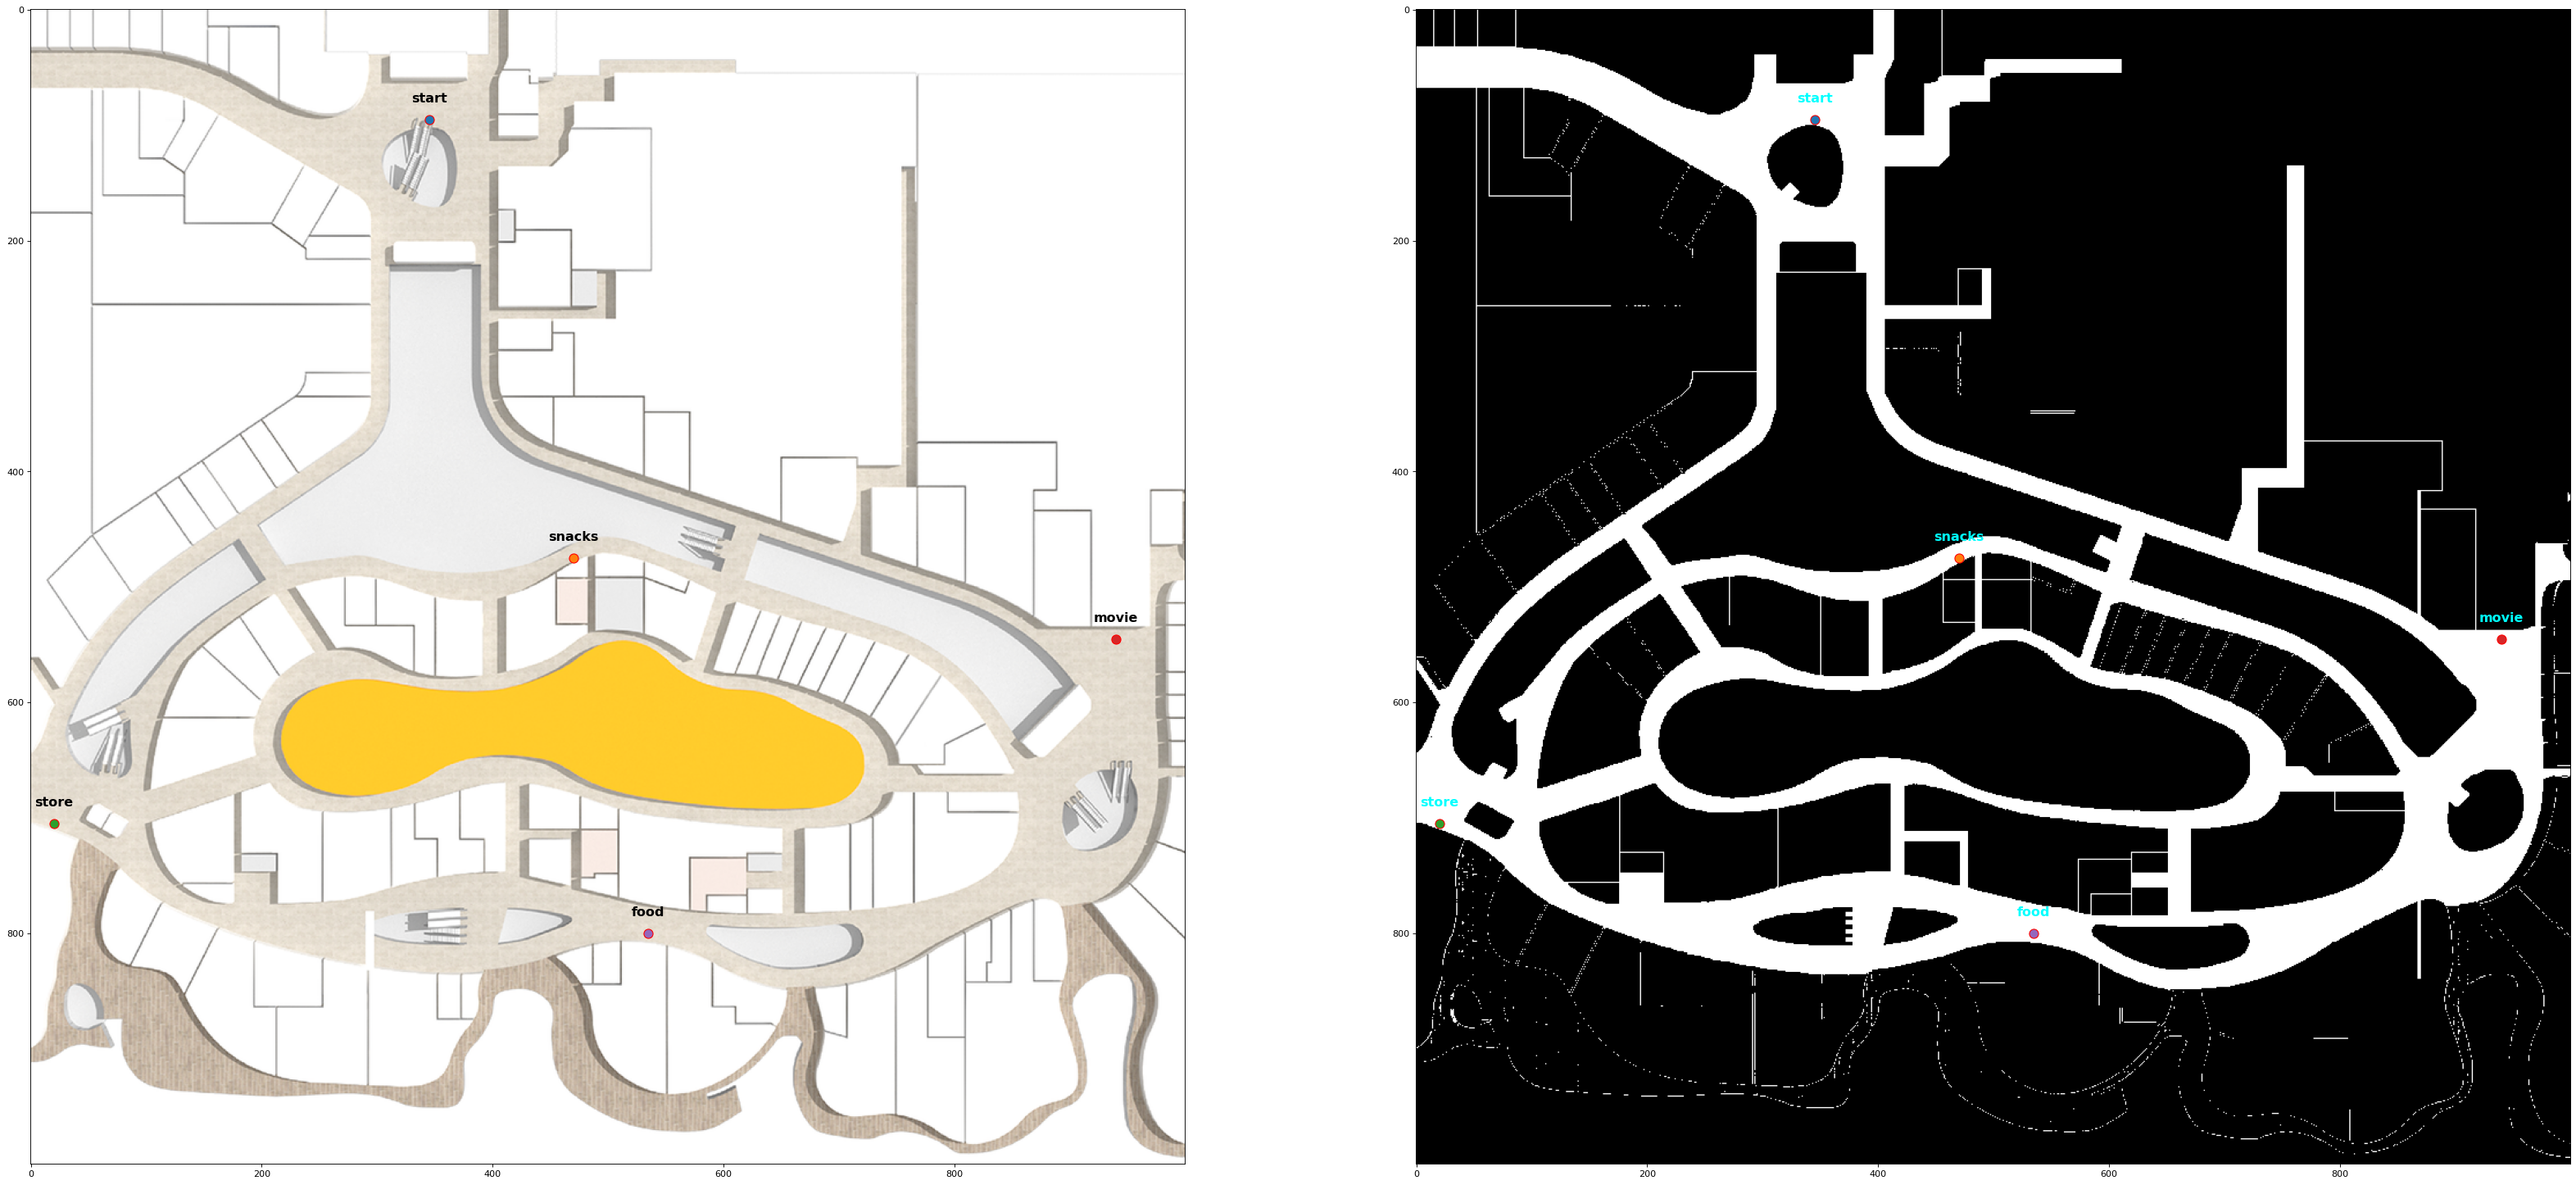

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
floor_plan = imageio.v2.imread('./map/vivocity.png')
grid_map_img = imageio.v2.imread('./map/vivocity_freespace.png')

grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))
# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality
# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map
plt.figure(figsize=(50, 50), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()
# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Common Code-plotting

In [3]:
# Save as npy
# image_path = "./map/vivocity_freespace.png"
# img = Image.open(image_path).convert('L')
# obstacle_map = np.array(img) == 0
# obstacle_map_uint8 = obstacle_map.astype(np.uint8)
# np.save("./map/obstacle_map.npy", obstacle_map_uint8)

def plot_path_on_map(start_x, start_y, goal_x, goal_y, path_x, path_y):
    plt.plot(start_x, start_y, "or")
    plt.plot(goal_x, goal_y, "og")
    plt.plot(path_x, path_y, "-b")


def plot_complete_tsp_path(order, locations):
    obstacle_map_path = "./map/obstacle_map.npy"
    obstacle_map = np.load(obstacle_map_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_map_img, cmap='gray', origin='upper')

    for i in range(len(order) - 1):
        start = order[i]
        end = order[i + 1]
        print(f"Path from {start} to {end}: Distance = {distances[(start, end)]:.2f} meters")

        if (start, end) in paths:
            route = paths[(start, end)]
            route_x, route_y = zip(*route)
            plot_path_on_map(locations[start][0], locations[start][1], locations[end][0], locations[end][1], route_x, route_y)

    for location, (x, y) in locations.items():
        plt.text(x, y, location, color='cyan', fontsize=9)

    plt.title('Complete TSP Path on Map')
    plt.axis('equal')
    plt.show()


paths = {}
distances = {}
def navigate_and_plot(locations, start_key, goal_key, planner, algorithm='dijkstra'):
    sx, sy = locations[start_key]
    gx, gy = locations[goal_key]
    start_time = time.time()

    if algorithm == 'gbfs':
        rx, ry = planner.planning_gbfs(sx, sy, gx, gy)
    elif algorithm == 'dijkstra':
        rx, ry = planner.planning_dijkstra(sx, sy, gx, gy)
    elif algorithm == 'astar':
        rx, ry = planner.planning_astar(sx, sy, gx, gy)
    else:
        raise ValueError(f"Invalid algorithm: {algorithm}")

    end_time = time.time()
    total_distance = planner.calculate_total_distance(rx, ry)

    distances[(start_key, goal_key)] = total_distance

    paths[(start_key, goal_key)] = list(zip(rx, ry))

    print(f"Path from {start_key} to {goal_key} planned in {end_time - start_time:.2f} seconds, total distance: {total_distance:.2f} meters.")
    plot_path_on_map(sx, sy, gx, gy, rx, ry)
    print("-------------------------------------------------------------------------------------------------------------------")

def plot_all_paths(locations, planner, algorithm='dijkstra'):
    obstacle_map_path = "./map/obstacle_map.npy"
    obstacle_map = np.load(obstacle_map_path)
    for start_key in locations:
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_map_img, cmap='gray', origin='upper')

        for goal_key in locations:
            if start_key != goal_key:
                navigate_and_plot(locations, start_key, goal_key, planner, algorithm)

        for location, (x, y) in locations.items():
            plt.text(x, y, location, color='cyan', fontsize=9)

        plt.grid(True)
        plt.axis('equal')
        plt.title(f"Paths from {start_key}")
        plt.show()

## Task 1

## Planner-parent class

In [4]:
class Planner:
    def __init__(self, obstacle_map, resolution, robot_radius):
        self.obstacle_map = obstacle_map
        self.resolution = resolution
        self.robot_radius = robot_radius
        self.min_x, self.min_y = 0, 0
        self.max_x, self.max_y = obstacle_map.shape
        self.x_width = self.max_x
        self.y_width = self.max_y
        self.motion = self.get_motion_model()

    class Node:
        def __init__(self, x, y, cost, parent_index):
            self.x = x
            self.y = y
            self.cost = cost
            self.parent_index = parent_index

        def __str__(self):
            return f"{self.x},{self.y},{self.cost},{self.parent_index}"

    # Robot movement model, able to move to any of the 8 surrounding grid cells in each step
    @staticmethod
    def get_motion_model():
        # [dx, dy, cost]
        motion = [[1, 0, 1],  # Right
                  [0, 1, 1],  # Up
                  [-1, 0, 1],  # Left
                  [0, -1, 1],  # Down
                  [-1, -1, math.sqrt(2)],  # Down-Left
                  [-1, 1, math.sqrt(2)],  # Up-Left
                  [1, -1, math.sqrt(2)],  # Down-Right
                  [1, 1, math.sqrt(2)]]  # Up-Right
        return motion

    @staticmethod
    def calc_position(index, minp):
        pos = minp + index
        return pos

    @staticmethod
    def calc_xy_index(position, minp):
        return round(position - minp)

    def calc_index(self, node):
        return node.y * self.x_width + node.x

    def verify_node(self, node):
        if node.x < 0 or node.y < 0 or node.x >= self.x_width or node.y >= self.y_width:
            return False
        max_distance = self.robot_radius / self.resolution # Each grid is 0.2m, so a radius of 0.3m is approximately 1.5 grids
        for dx in range(-int(math.ceil(max_distance)), int(math.ceil(max_distance)) + 1):
            for dy in range(-int(math.ceil(max_distance)), int(math.ceil(max_distance)) + 1):
                distance = math.sqrt((dx + 0.5)**2 + (dy + 0.5)**2)
                if distance > max_distance:
                    continue
                check_x = node.x + dx
                check_y = node.y + dy
                if check_x < 0 or check_y < 0 or check_x >= self.x_width or check_y >= self.y_width:
                    continue
                if self.obstacle_map[check_y, check_x]:
                    return False
        return True


    def calc_final_path(self, goal_node, closed_set):
        rx = [self.calc_position(goal_node.x, self.min_x)]
        ry = [self.calc_position(goal_node.y, self.min_y)]
        parent_index = goal_node.parent_index
        while parent_index != -1:
            n = closed_set[parent_index]
            rx.append(self.calc_position(n.x, self.min_x))
            ry.append(self.calc_position(n.y, self.min_y))
            parent_index = n.parent_index
        return rx, ry

    def calculate_total_distance(self, rx, ry):
        """
        Calculate the total distance of the path based on the resolution.
        """
        total_distance = 0.0
        for i in range(1, len(rx)):
            dx = rx[i] - rx[i - 1]
            dy = ry[i] - ry[i - 1]
            distance = math.sqrt(dx ** 2 + dy ** 2) * self.resolution
            total_distance += distance
        return total_distance

## GBFS

Starting GBFS program...
Start GBFS Path Planning...
Initialized start node at (345, 95) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 4803
Path from start to snacks planned in 0.40 seconds, total distance: 146.12 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (345, 95) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 740
Path from start to store planned in 0.08 seconds, total distance: 163.30 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (345, 95) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 1999
Path from start to movie planned in 0.17 seconds, total distance: 183.61 meters.
------------------------

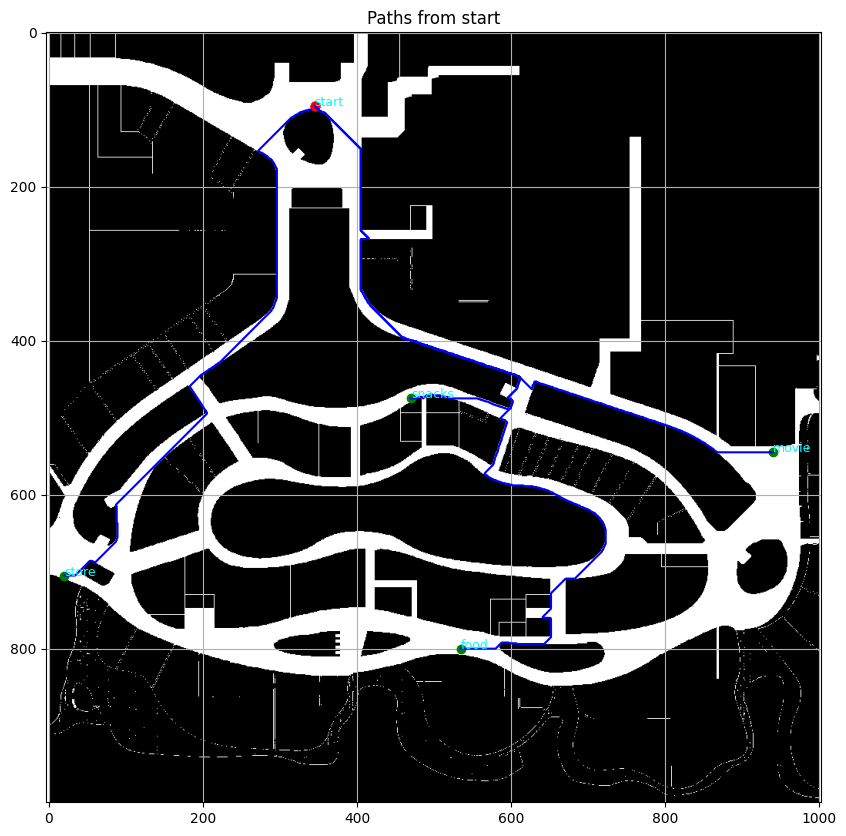

Start GBFS Path Planning...
Initialized start node at (470, 475) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 4580
Path from snacks to start planned in 0.37 seconds, total distance: 161.38 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (470, 475) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 532
Path from snacks to store planned in 0.05 seconds, total distance: 122.90 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (470, 475) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 841
Path from snacks to movie planned in 0.08 seconds, total distance: 142.36 meters.
----------------------------------------------

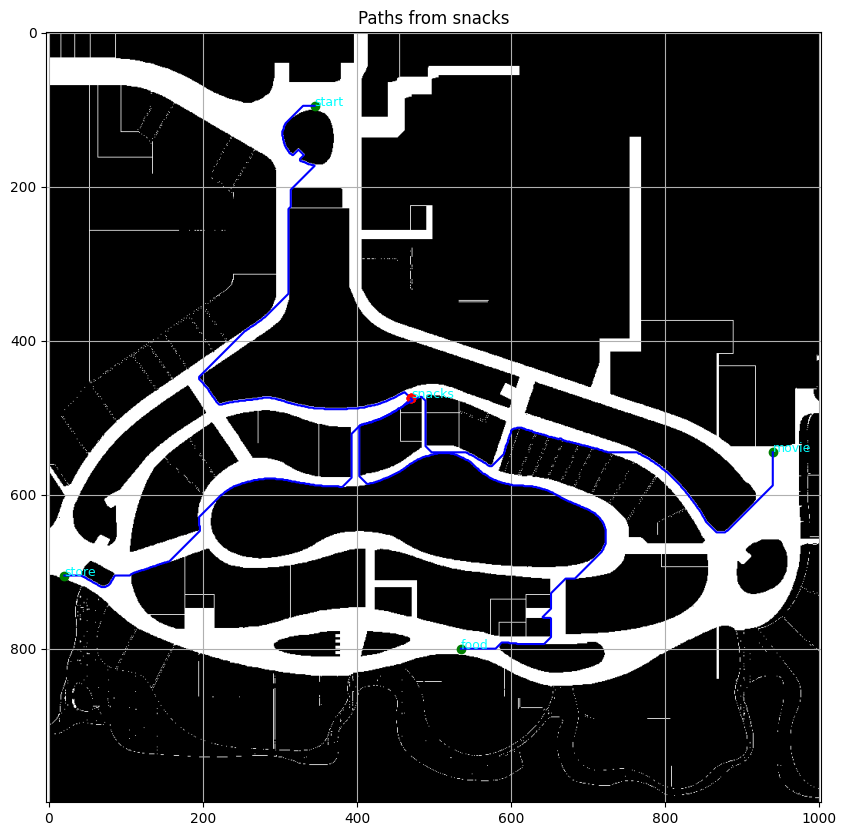

Start GBFS Path Planning...
Initialized start node at (20, 705) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 877
Path from store to start planned in 0.09 seconds, total distance: 174.34 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (20, 705) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 538
Path from store to snacks planned in 0.05 seconds, total distance: 120.87 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (20, 705) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 1367
Path from store to movie planned in 0.19 seconds, total distance: 255.88 meters.
--------------------------------------------------

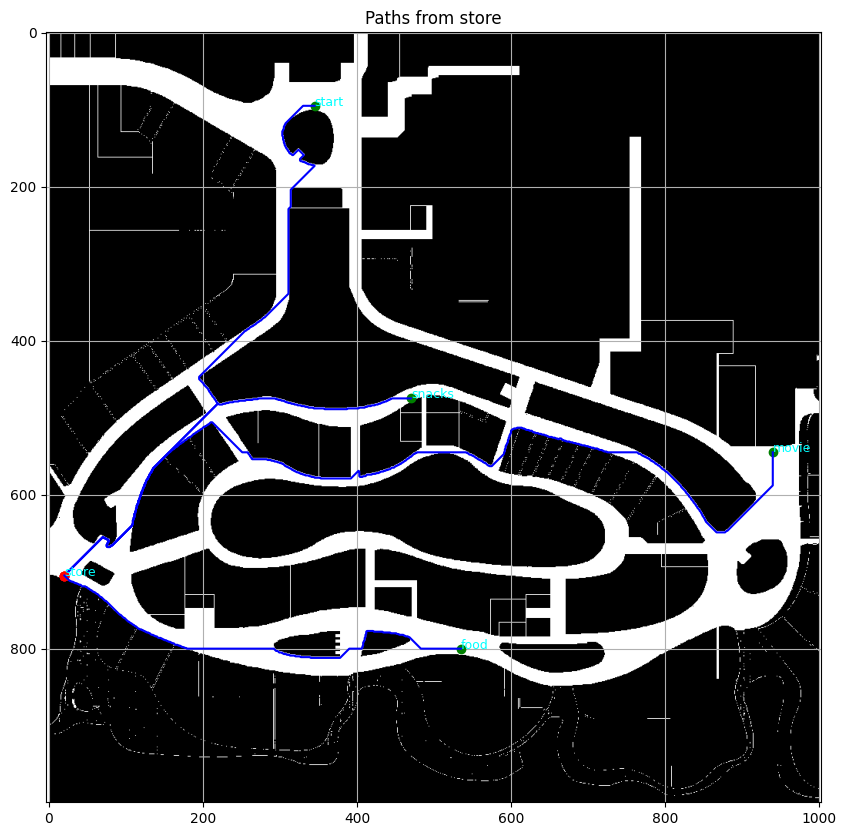

Start GBFS Path Planning...
Initialized start node at (940, 545) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 5598
Path from movie to start planned in 0.44 seconds, total distance: 195.40 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (940, 545) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 688
Path from movie to snacks planned in 0.07 seconds, total distance: 108.54 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (940, 545) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 1015
Path from movie to store planned in 0.11 seconds, total distance: 238.97 meters.
-----------------------------------------------

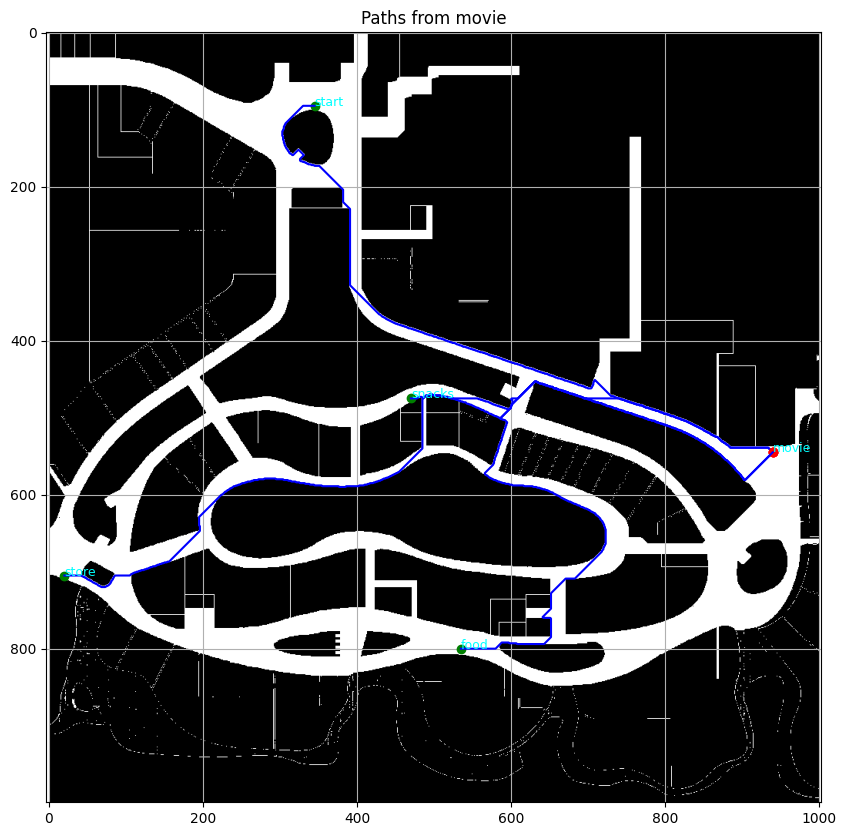

Start GBFS Path Planning...
Initialized start node at (535, 800) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 8436
Path from food to start planned in 0.85 seconds, total distance: 249.60 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (535, 800) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 13342
Path from food to snacks planned in 0.92 seconds, total distance: 182.02 meters.
-------------------------------------------------------------------------------------------------------------------
Start GBFS Path Planning...
Initialized start node at (535, 800) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 660
Path from food to store planned in 0.07 seconds, total distance: 131.85 meters.
-------------------------------------------------

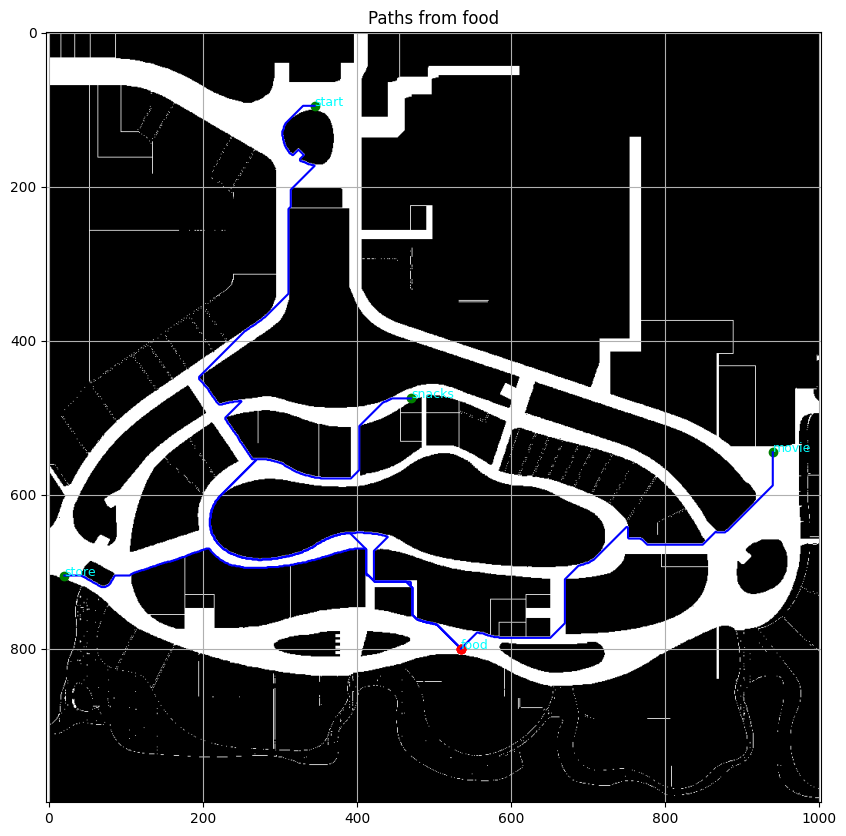

In [5]:
class GBFS(Planner):
    class Node(Planner.Node):
        def __init__(self, x, y, cost, parent_index, h=0):
            super().__init__(x, y, cost, parent_index)
            self.h = h  # Heuristic value (distance to goal)

    @staticmethod
    def heuristic(x, y, goal_x, goal_y):
        # Using Euclidean distance as heuristic
        return math.sqrt((x - goal_x) ** 2 + (y - goal_y) ** 2)

    def planning_gbfs(self, sx, sy, gx, gy):
        print("Start GBFS Path Planning...")
        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1,
                               self.heuristic(sx, sy, gx, gy))
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)
        print(f"Initialized start node at ({sx}, {sy}) and goal node at ({gx}, {gy}).")
        open_set, closed_set = dict(), dict()
        open_set[self.calc_index(start_node)] = start_node
        visited_nodes_count = 0
        while True:
            if not open_set:
                break
            c_id = min(open_set, key=lambda o: open_set[o].h)  # Sort by heuristic value
            current = open_set[c_id]

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Goal reached. Calculating final path...")
                goal_node.parent_index = current.parent_index
                break

            del open_set[c_id]
            closed_set[c_id] = current
            visited_nodes_count += 1

            for move_x, move_y, move_cost in self.motion:
                node = self.Node(current.x + move_x,
                                 current.y + move_y,
                                 current.cost + move_cost, c_id,
                                 self.heuristic(current.x + move_x, current.y + move_y, gx, gy))
                n_id = self.calc_index(node)

                if n_id in closed_set or not self.verify_node(node):
                    continue

                if n_id not in open_set or node.h < open_set[n_id].h:
                    open_set[n_id] = node
        print(f"Visited nodes count: {visited_nodes_count}")
        rx, ry = self.calc_final_path(goal_node, closed_set)
        return rx, ry

def main():

    global distances, paths
    distances = {}
    paths = {}

    locations = {
        'start': [345, 95],
        'snacks': [470, 475],
        'store': [20, 705],
        'movie': [940, 545],
        'food': [535, 800],
    }

    obstacle_map_path = "./map/obstacle_map.npy"
    obstacle_map = np.load(obstacle_map_path)

    grid_size = 0.2
    robot_radius = 0.3
    print("Starting GBFS program...")
    planner = GBFS(obstacle_map, grid_size, robot_radius)
    plot_all_paths(locations, planner, algorithm='gbfs')

if __name__ == '__main__':
    main()


## Dijkstra

Starting Dijkstra program...
Start Dijkstra Path Planning...
Initialized start node at (345, 95) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 76048
Path from start to snacks planned in 3.73 seconds, total distance: 141.97 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (345, 95) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 90099
Path from start to store planned in 7.43 seconds, total distance: 154.66 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (345, 95) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 107307
Path from start to movie planned in 9.33 seconds, total distance: 178.66 meters.
---

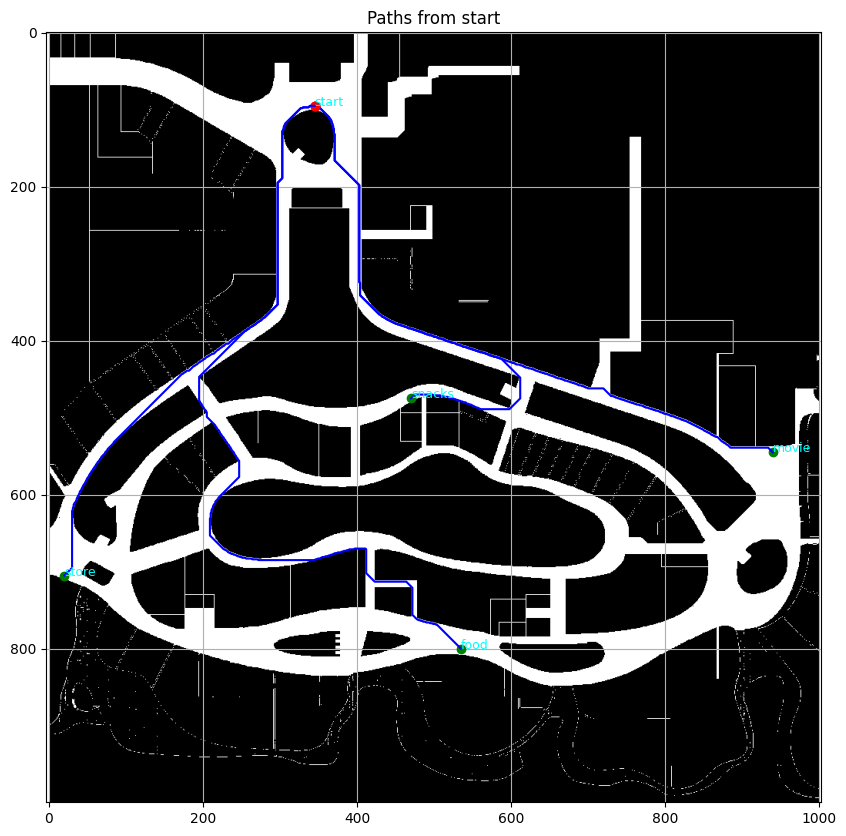

Start Dijkstra Path Planning...
Initialized start node at (470, 475) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 133182
Path from snacks to start planned in 13.59 seconds, total distance: 141.97 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (470, 475) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 87708
Path from snacks to store planned in 8.36 seconds, total distance: 114.56 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (470, 475) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 71899
Path from snacks to movie planned in 6.58 seconds, total distance: 106.94 meters.
---------------------------

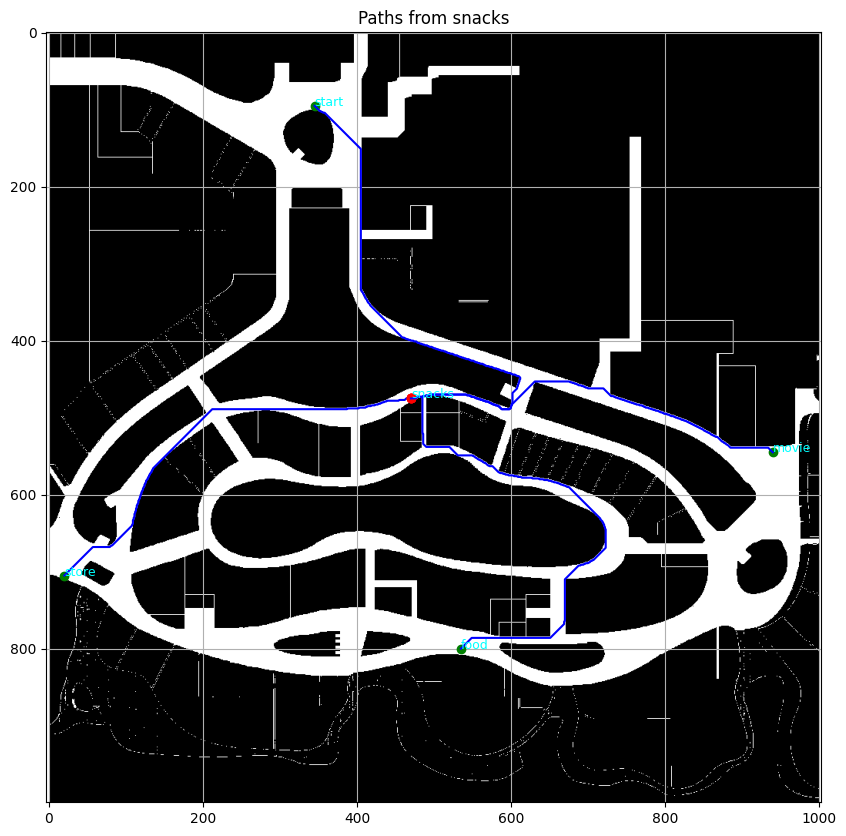

Start Dijkstra Path Planning...
Initialized start node at (20, 705) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 98389
Path from store to start planned in 4.90 seconds, total distance: 154.66 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (20, 705) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 63239
Path from store to snacks planned in 2.94 seconds, total distance: 114.56 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (20, 705) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 158095
Path from store to movie planned in 7.96 seconds, total distance: 209.09 meters.
--------------------------------

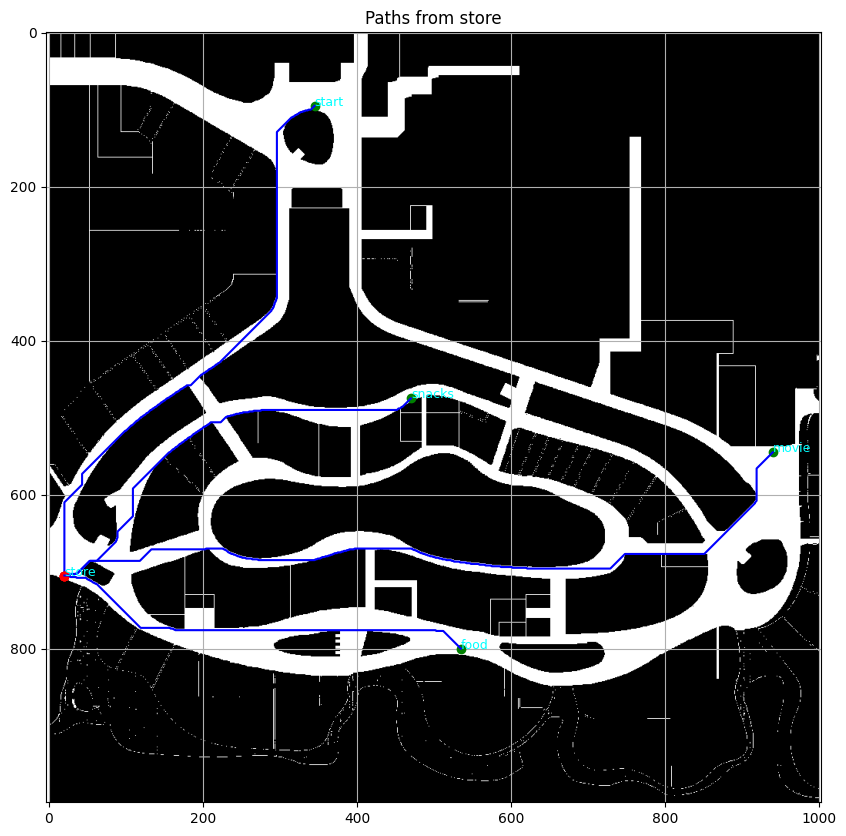

Start Dijkstra Path Planning...
Initialized start node at (940, 545) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 120609
Path from movie to start planned in 5.72 seconds, total distance: 178.66 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (940, 545) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 61461
Path from movie to snacks planned in 2.79 seconds, total distance: 106.94 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (940, 545) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 154358
Path from movie to store planned in 7.54 seconds, total distance: 209.09 meters.
-----------------------------

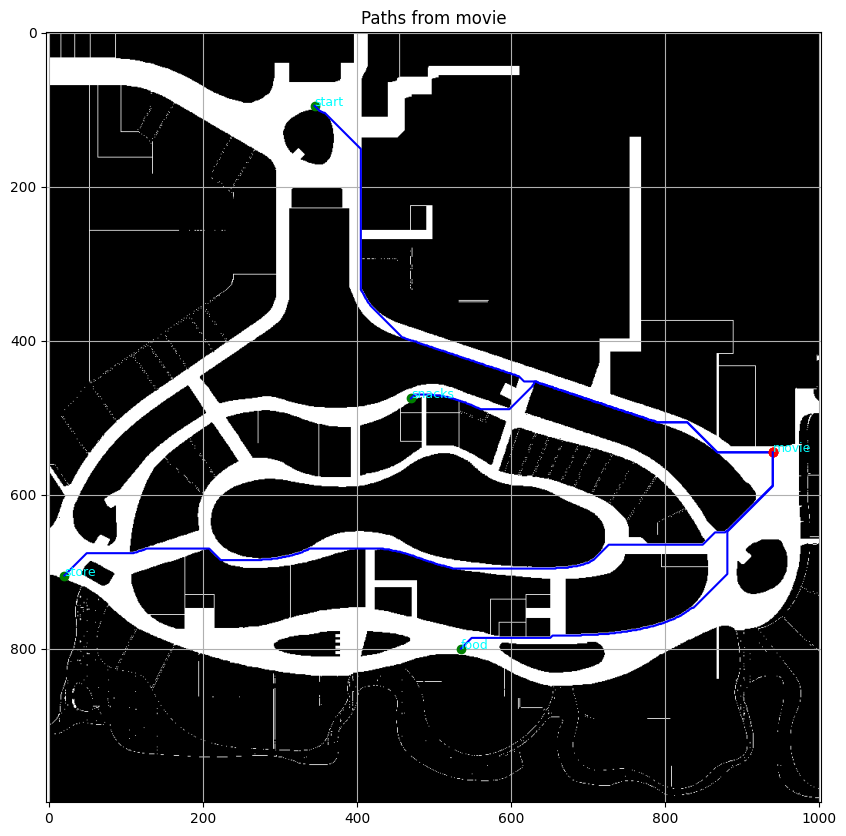

Start Dijkstra Path Planning...
Initialized start node at (535, 800) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 145930
Path from food to start planned in 7.90 seconds, total distance: 221.77 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (535, 800) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 104164
Path from food to snacks planned in 5.85 seconds, total distance: 132.68 meters.
-------------------------------------------------------------------------------------------------------------------
Start Dijkstra Path Planning...
Initialized start node at (535, 800) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 79467
Path from food to store planned in 4.29 seconds, total distance: 110.87 meters.
--------------------------------

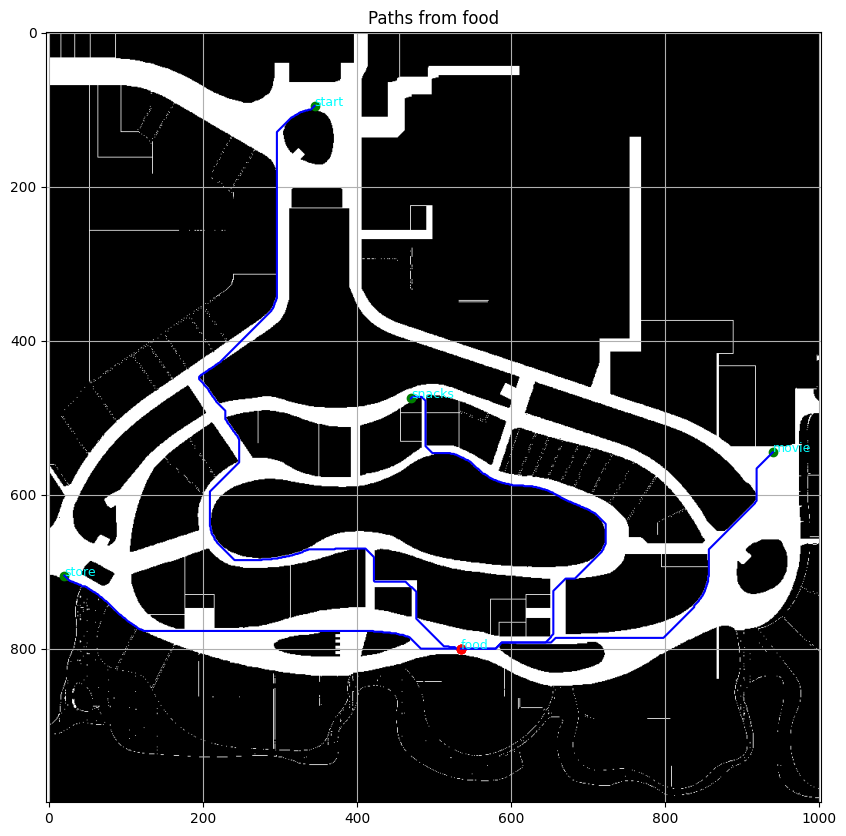

In [6]:
class Dijkstra(Planner):
    def planning_dijkstra(self, sx, sy, gx, gy):
        print("Start Dijkstra Path Planning...")
        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)
        print(f"Initialized start node at ({sx}, {sy}) and goal node at ({gx}, {gy}).")
        open_set, closed_set = dict(), dict()
        open_set[self.calc_index(start_node)] = start_node
        # print(f"Added start node to open set. Open set size: {len(open_set)}")
        visited_nodes_count = 0
        while True:
            if not open_set:
                # print("Open set is empty, no path found.")
                break
            c_id = min(open_set, key=lambda o: open_set[o].cost)
            current = open_set[c_id]
            # print(f"Current node: {current}")

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Goal reached. Calculating final path...")
                goal_node.cost = current.cost
                goal_node.parent_index = current.parent_index
                break

            del open_set[c_id]
            closed_set[c_id] = current
            visited_nodes_count += 1

            for move_x, move_y, move_cost in self.motion:
                node = self.Node(current.x + move_x,
                                 current.y + move_y,
                                 current.cost + move_cost, c_id)
                n_id = self.calc_index(node)

                if n_id in closed_set or not self.verify_node(node):
                    continue

                if n_id not in open_set or node.cost < open_set[n_id].cost:
                    open_set[n_id] = node
        print(f"Visited nodes count: {visited_nodes_count}")
        rx, ry = self.calc_final_path(goal_node, closed_set)
        return rx, ry

def main():

    global distances, paths
    distances = {}
    paths = {}

    locations = {
        'start':  [345, 95],    # Level 2 Escalator
        'snacks': [470, 475],   # Garrett Popcorn
        'store':  [20, 705],    # DJI Store
        'movie':  [940, 545],   # Golden Village
        'food':   [535, 800],   # PUTIEN
    }

    obstacle_map_path = "./map/obstacle_map.npy"
    obstacle_map = np.load(obstacle_map_path)
    grid_size = 0.2
    robot_radius = 0.3
    print("Starting Dijkstra program...")
    planner = Dijkstra(obstacle_map, grid_size, robot_radius)
    plot_all_paths(locations, planner, algorithm='dijkstra')

if __name__ == '__main__':
    main()

## A-Start

Starting A* program...
Start A* Path Planning...
Initialized start node at (345, 95) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 39161
Path from start to snacks planned in 7.43 seconds, total distance: 141.97 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (345, 95) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 31528
Path from start to store planned in 10.34 seconds, total distance: 154.66 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (345, 95) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 34370
Path from start to movie planned in 6.47 seconds, total distance: 178.66 meters.
---------------------------

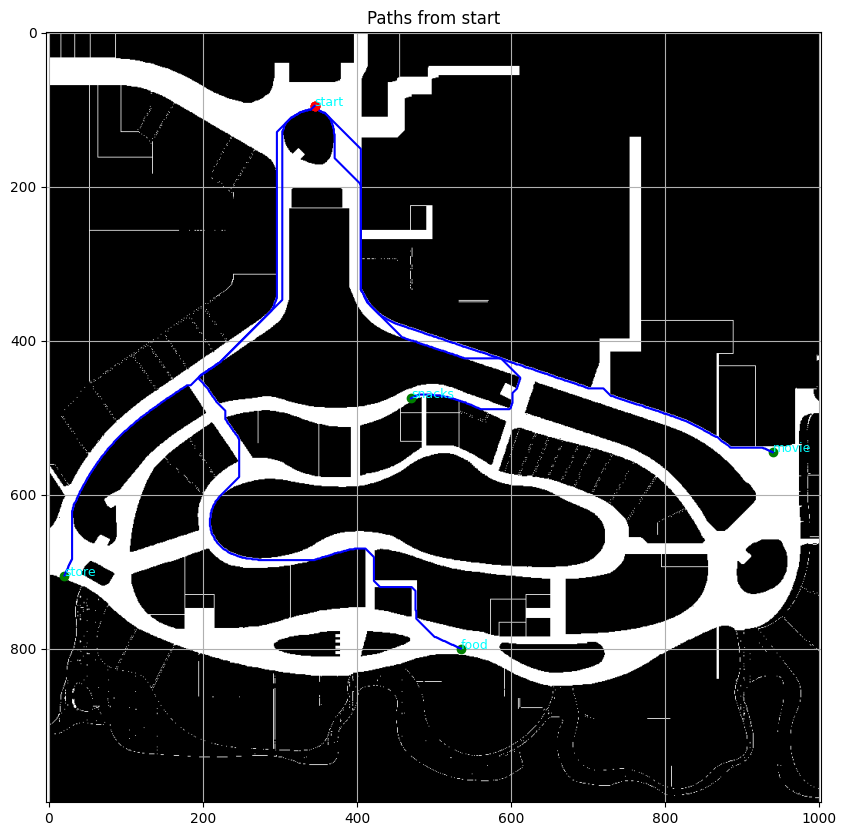

Start A* Path Planning...
Initialized start node at (470, 475) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 27560
Path from snacks to start planned in 5.15 seconds, total distance: 141.97 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (470, 475) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 16762
Path from snacks to store planned in 2.91 seconds, total distance: 114.56 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (470, 475) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 13359
Path from snacks to movie planned in 1.57 seconds, total distance: 106.94 meters.
-----------------------------------------------

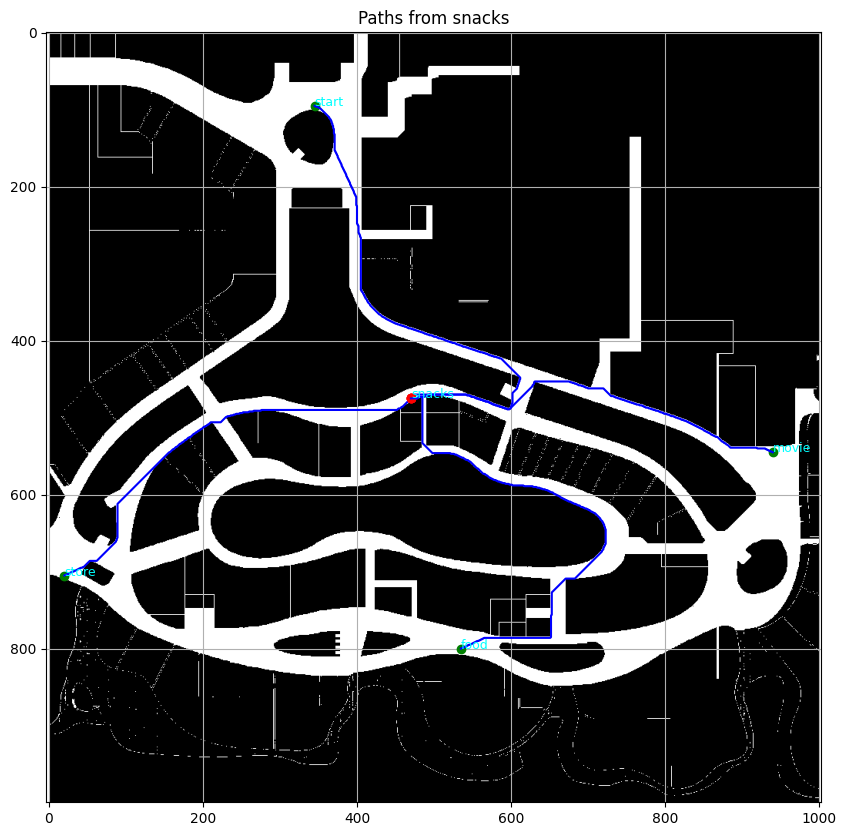

Start A* Path Planning...
Initialized start node at (20, 705) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 27677
Path from store to start planned in 5.02 seconds, total distance: 154.66 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (20, 705) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 25987
Path from store to snacks planned in 5.64 seconds, total distance: 114.56 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (20, 705) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 72161
Path from store to movie planned in 24.68 seconds, total distance: 209.09 meters.
--------------------------------------------------

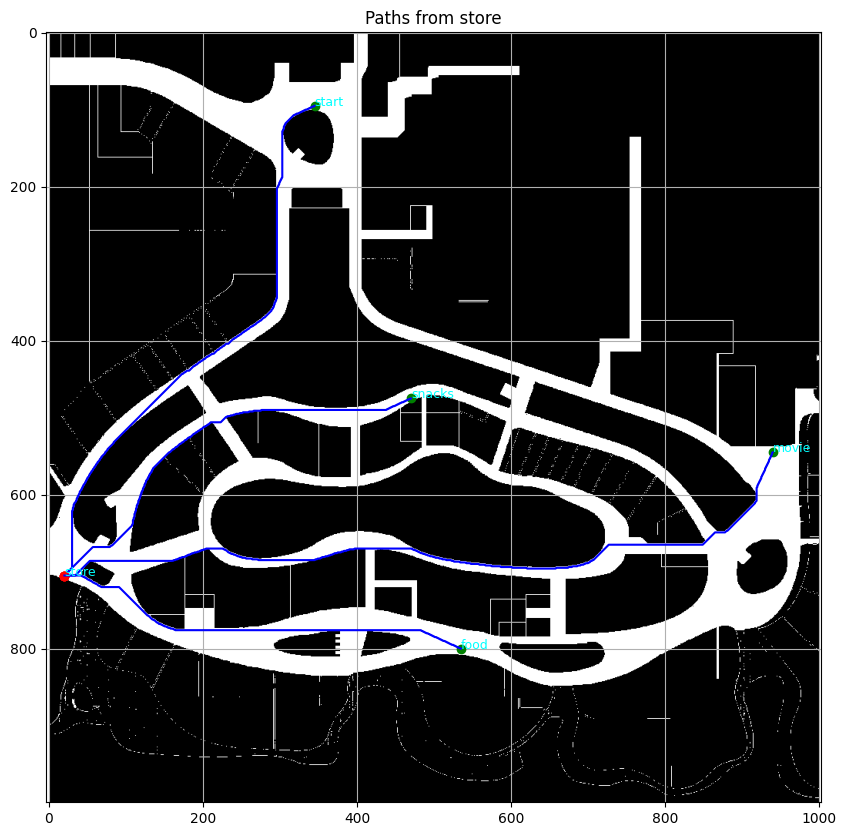

Start A* Path Planning...
Initialized start node at (940, 545) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 27328
Path from movie to start planned in 4.97 seconds, total distance: 178.66 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (940, 545) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 12157
Path from movie to snacks planned in 1.77 seconds, total distance: 106.94 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (940, 545) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 44096
Path from movie to store planned in 14.55 seconds, total distance: 209.09 meters.
------------------------------------------------

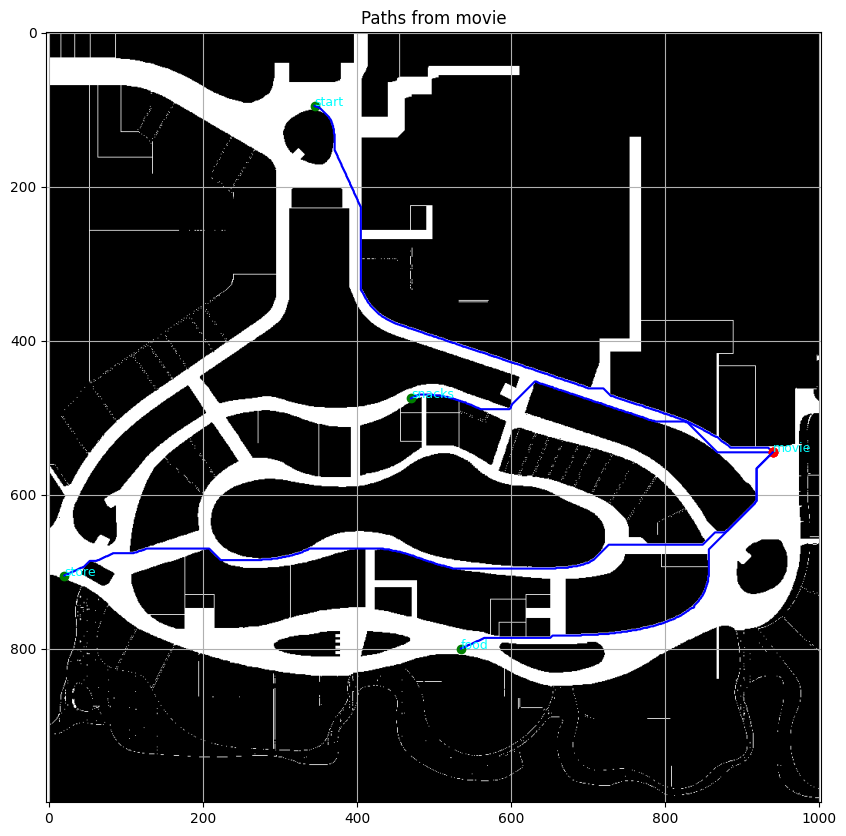

Start A* Path Planning...
Initialized start node at (535, 800) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 73972
Path from food to start planned in 17.24 seconds, total distance: 221.77 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (535, 800) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 38265
Path from food to snacks planned in 6.19 seconds, total distance: 132.68 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (535, 800) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 22759
Path from food to store planned in 6.12 seconds, total distance: 110.87 meters.
---------------------------------------------------

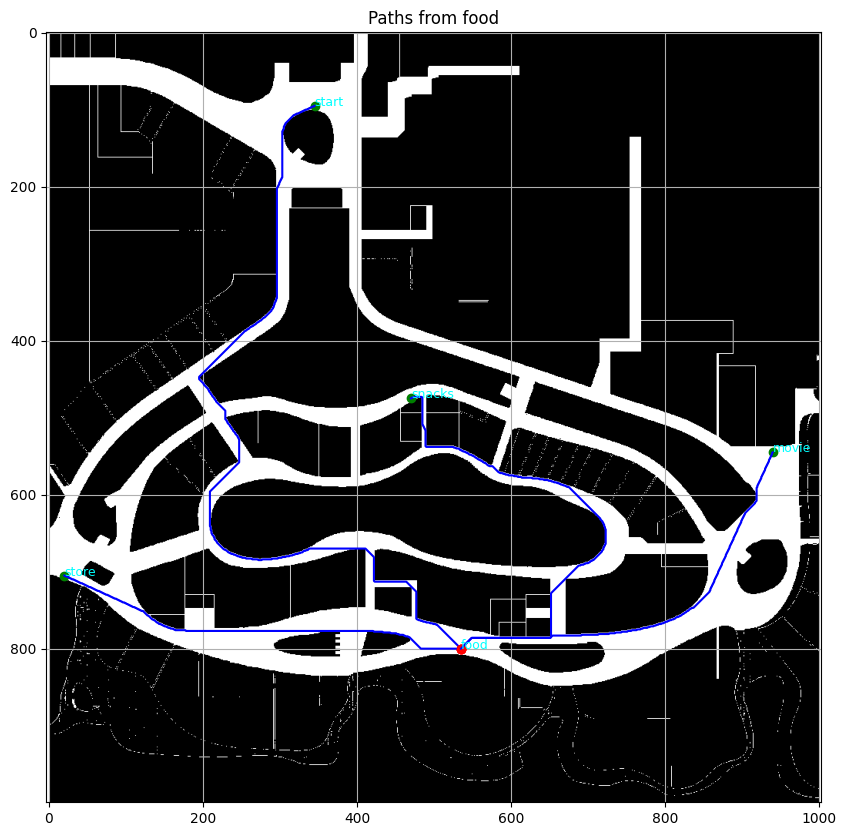

In [7]:
# ------------------------------ #
# Heuristic function for A*
# ------------------------------ #
class Heuristic:
    @staticmethod
    def euclidean_distance(x1, y1, x2, y2):
        return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    @staticmethod
    def manhattan_distance(x1, y1, x2, y2):
        return abs(x2 - x1) + abs(y2 - y1)

class AStar(Planner):
    def __init__(self, obstacle_map, resolution, robot_radius):
        super().__init__(obstacle_map, resolution, robot_radius)
        self.heuristic = Heuristic.euclidean_distance
        # self.heuristic = Heuristic.manhattan_distance

    def planning_astar(self, sx, sy, gx, gy):
        print("Start A* Path Planning...")
        start_node = self.Node(self.calc_xy_index(sx, self.min_x),
                               self.calc_xy_index(sy, self.min_y), 0.0, -1)
        goal_node = self.Node(self.calc_xy_index(gx, self.min_x),
                              self.calc_xy_index(gy, self.min_y), 0.0, -1)
        print(f"Initialized start node at ({sx}, {sy}) and goal node at ({gx}, {gy}).")
        open_set, closed_set = dict(), dict()
        open_set[self.calc_index(start_node)] = start_node
        visited_nodes_count = 0
        while True:
            if not open_set:
                print("Open set is empty, no path found.")
                break

            c_id = min(open_set, key=lambda o: open_set[o].cost + self.heuristic(open_set[o].x, open_set[o].y, goal_node.x, goal_node.y))
            current = open_set[c_id]

            if current.x == goal_node.x and current.y == goal_node.y:
                print("Goal reached. Calculating final path...")
                goal_node.cost = current.cost
                goal_node.parent_index = current.parent_index
                break

            del open_set[c_id]
            closed_set[c_id] = current
            visited_nodes_count += 1

            for move_x, move_y, move_cost in self.motion:
                node = self.Node(current.x + move_x,
                                 current.y + move_y,
                                 current.cost + move_cost, c_id)
                n_id = self.calc_index(node)

                if n_id in closed_set or not self.verify_node(node):
                    continue

                if n_id not in open_set or node.cost + self.heuristic(node.x, node.y, goal_node.x, goal_node.y) < open_set[n_id].cost + self.heuristic(open_set[n_id].x, open_set[n_id].y, goal_node.x, goal_node.y):
                    open_set[n_id] = node

        print(f"Visited nodes count: {visited_nodes_count}")
        rx, ry = self.calc_final_path(goal_node, closed_set)
        return rx, ry

def main():

    global distances, paths
    distances = {}
    paths = {}

    obstacle_map_path = "./map/obstacle_map.npy"
    obstacle_map = np.load(obstacle_map_path)
    grid_size = 0.2
    robot_radius = 0.3

    print("Starting A* program...")
    planner = AStar(obstacle_map, grid_size, robot_radius)
    plot_all_paths(locations, planner, algorithm='astar')


if __name__ == '__main__':
    main()



## Task 2
## Storing Distances

Starting A* program...
Start A* Path Planning...
Initialized start node at (345, 95) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 39161
Path from start to snacks planned in 6.71 seconds, total distance: 141.97 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (345, 95) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 31528
Path from start to store planned in 10.20 seconds, total distance: 154.66 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (345, 95) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 34370
Path from start to movie planned in 6.74 seconds, total distance: 178.66 meters.
---------------------------

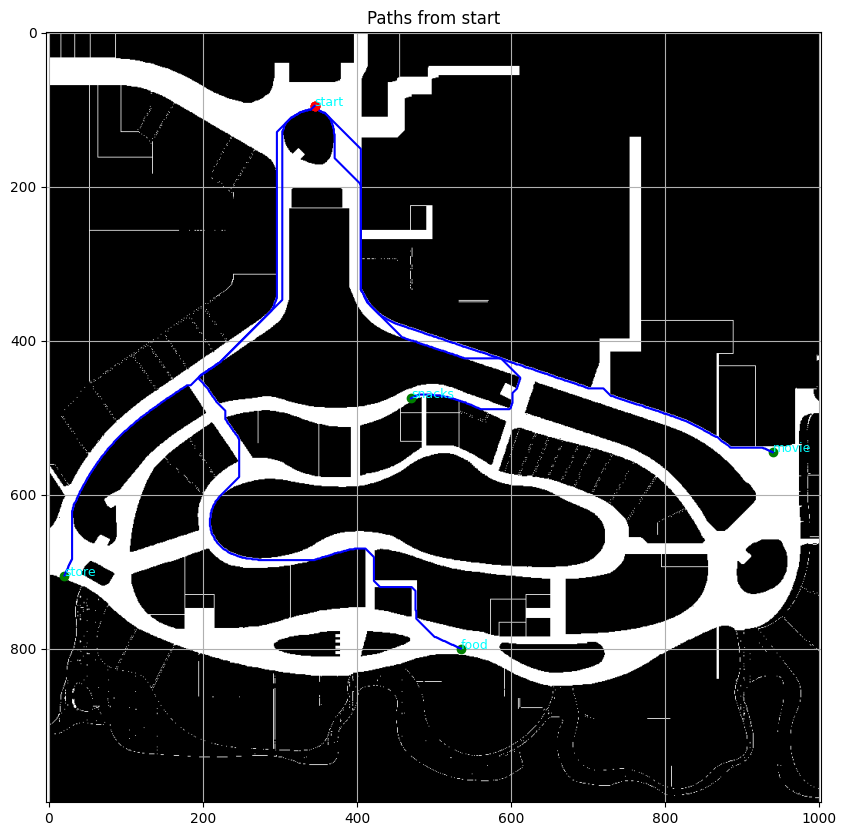

Start A* Path Planning...
Initialized start node at (470, 475) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 27560
Path from snacks to start planned in 4.96 seconds, total distance: 141.97 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (470, 475) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 16762
Path from snacks to store planned in 3.03 seconds, total distance: 114.56 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (470, 475) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 13359
Path from snacks to movie planned in 1.71 seconds, total distance: 106.94 meters.
-----------------------------------------------

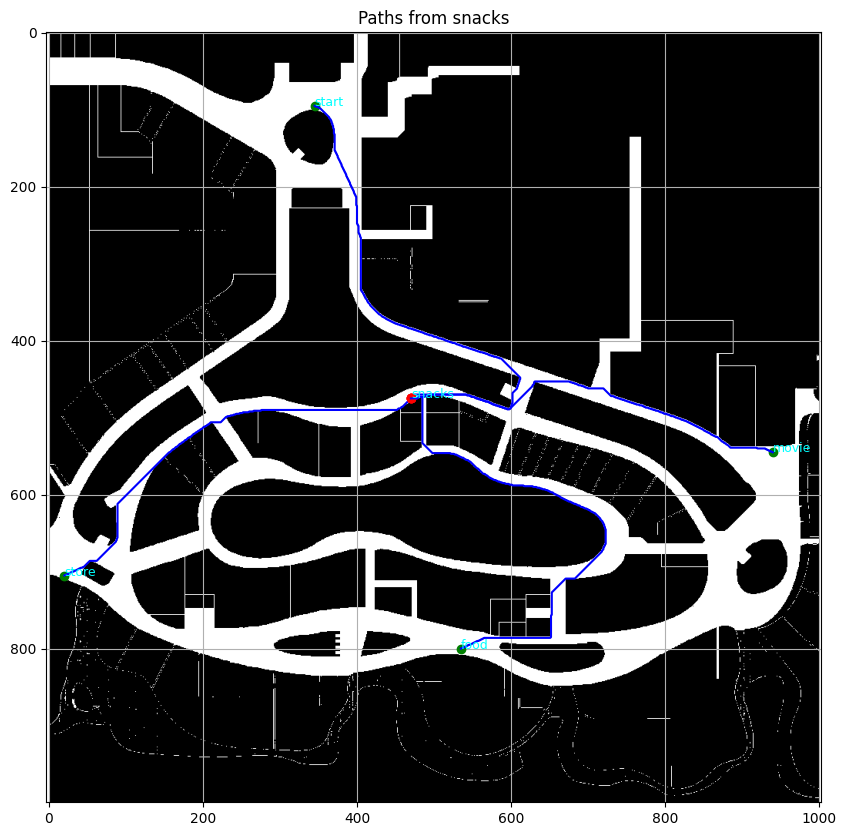

Start A* Path Planning...
Initialized start node at (20, 705) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 27677
Path from store to start planned in 5.91 seconds, total distance: 154.66 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (20, 705) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 25987
Path from store to snacks planned in 6.46 seconds, total distance: 114.56 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (20, 705) and goal node at (940, 545).
Goal reached. Calculating final path...
Visited nodes count: 72161
Path from store to movie planned in 28.09 seconds, total distance: 209.09 meters.
--------------------------------------------------

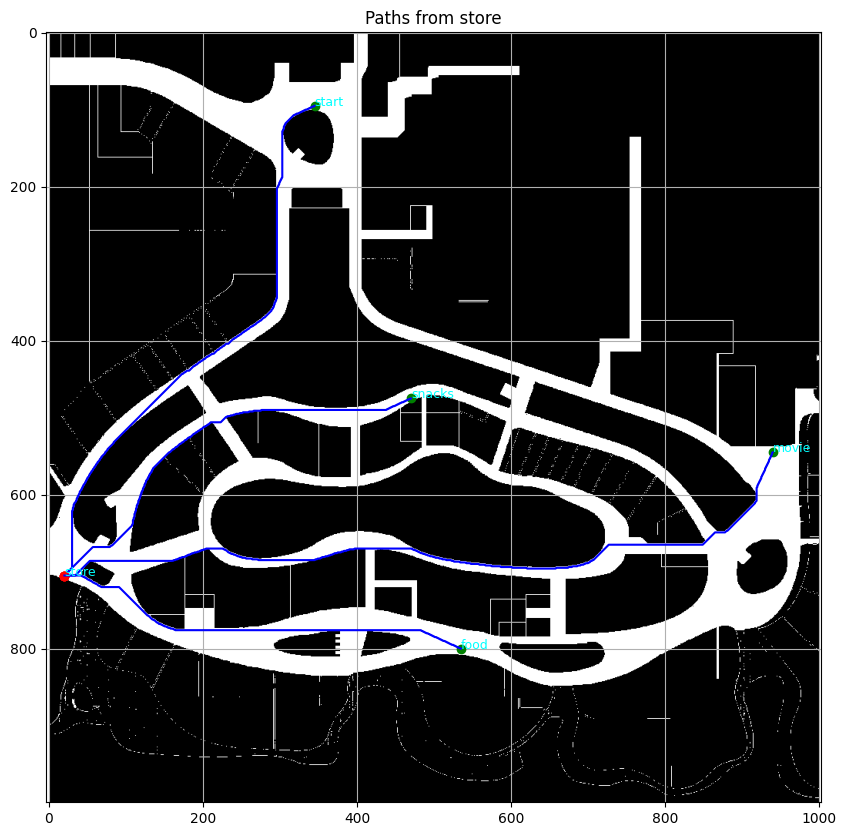

Start A* Path Planning...
Initialized start node at (940, 545) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 27328
Path from movie to start planned in 5.25 seconds, total distance: 178.66 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (940, 545) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 12157
Path from movie to snacks planned in 1.90 seconds, total distance: 106.94 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (940, 545) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 44096
Path from movie to store planned in 15.16 seconds, total distance: 209.09 meters.
------------------------------------------------

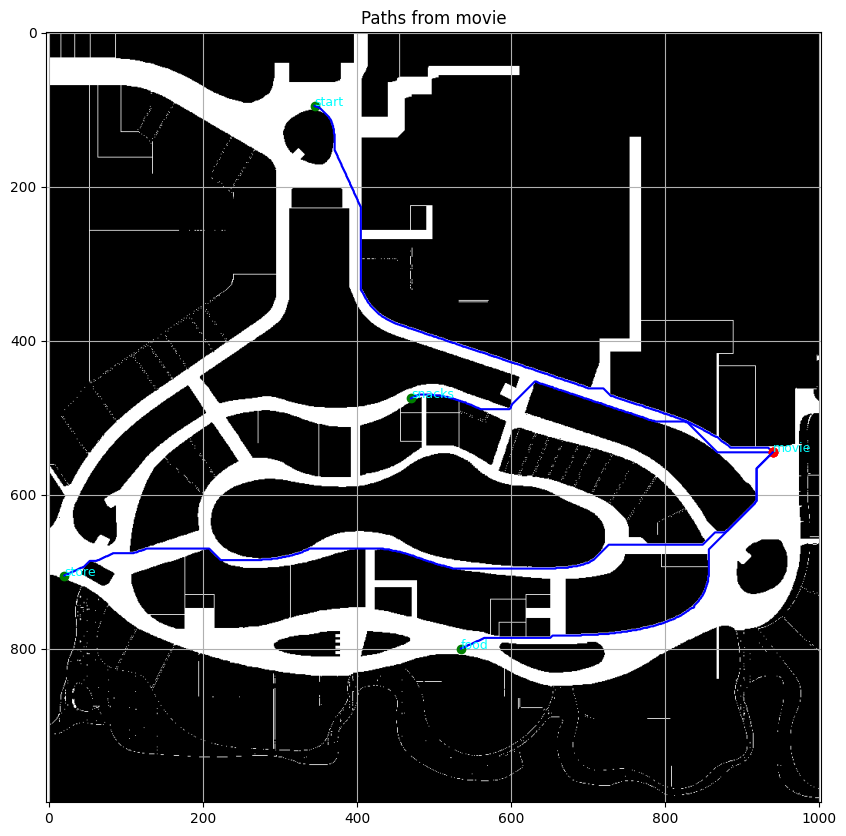

Start A* Path Planning...
Initialized start node at (535, 800) and goal node at (345, 95).
Goal reached. Calculating final path...
Visited nodes count: 73972
Path from food to start planned in 17.25 seconds, total distance: 221.77 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (535, 800) and goal node at (470, 475).
Goal reached. Calculating final path...
Visited nodes count: 38265
Path from food to snacks planned in 6.00 seconds, total distance: 132.68 meters.
-------------------------------------------------------------------------------------------------------------------
Start A* Path Planning...
Initialized start node at (535, 800) and goal node at (20, 705).
Goal reached. Calculating final path...
Visited nodes count: 22759
Path from food to store planned in 5.91 seconds, total distance: 110.87 meters.
---------------------------------------------------

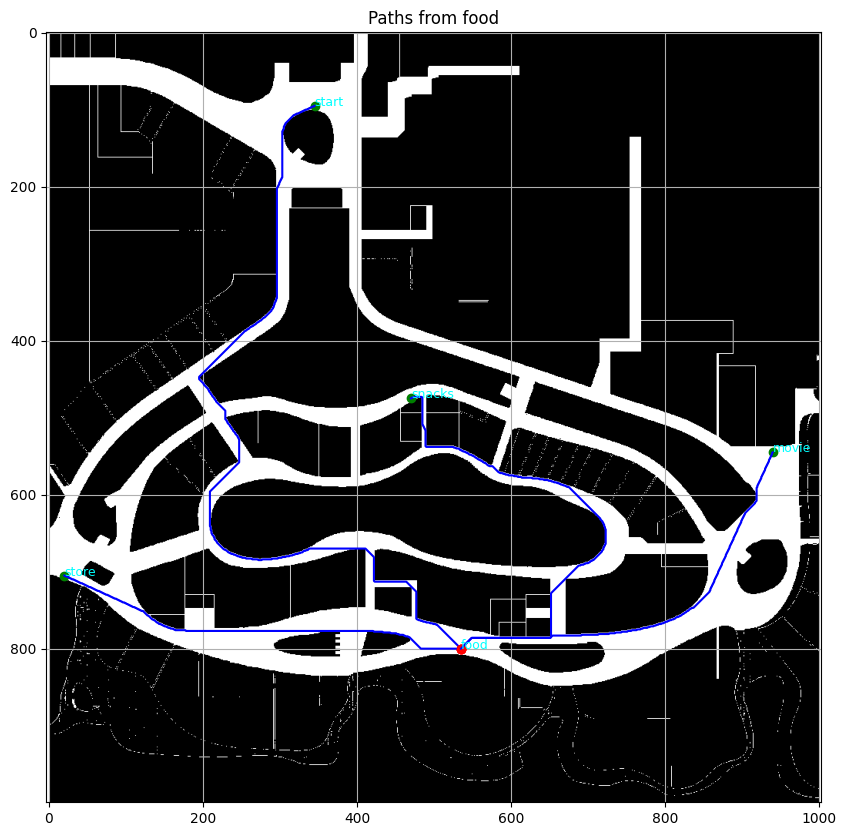

In [8]:
def get_distance_paths():
    global distances, paths
    distances = {}
    paths = {}

    obstacle_map_path = "./map/obstacle_map.npy"
    obstacle_map = np.load(obstacle_map_path)
    grid_size = 0.2
    robot_radius = 0.3

    print("Starting A* program...")
    planner = AStar(obstacle_map, grid_size, robot_radius)
    plot_all_paths(locations, planner, algorithm='astar')
get_distance_paths()

## TSP_Brute_Force(BF)

Starting TSP_Brute_Force(BF)...
Distance from start to snacks: 141.97
Distance from snacks to store: 114.56
Distance from store to movie: 209.09
Distance from movie to food: 113.72
Distance from food to start: 221.77
Total distance for this path: 801.11
-------------------------------------------------------------------------------------------------------------
Distance from start to snacks: 141.97
Distance from snacks to store: 114.56
Distance from store to food: 110.87
Distance from food to movie: 113.72
Distance from movie to start: 178.66
Total distance for this path: 659.78
-------------------------------------------------------------------------------------------------------------
Distance from start to snacks: 141.97
Distance from snacks to movie: 106.94
Distance from movie to store: 209.09
Distance from store to food: 110.87
Distance from food to start: 221.77
Total distance for this path: 790.64
----------------------------------------------------------------------------------

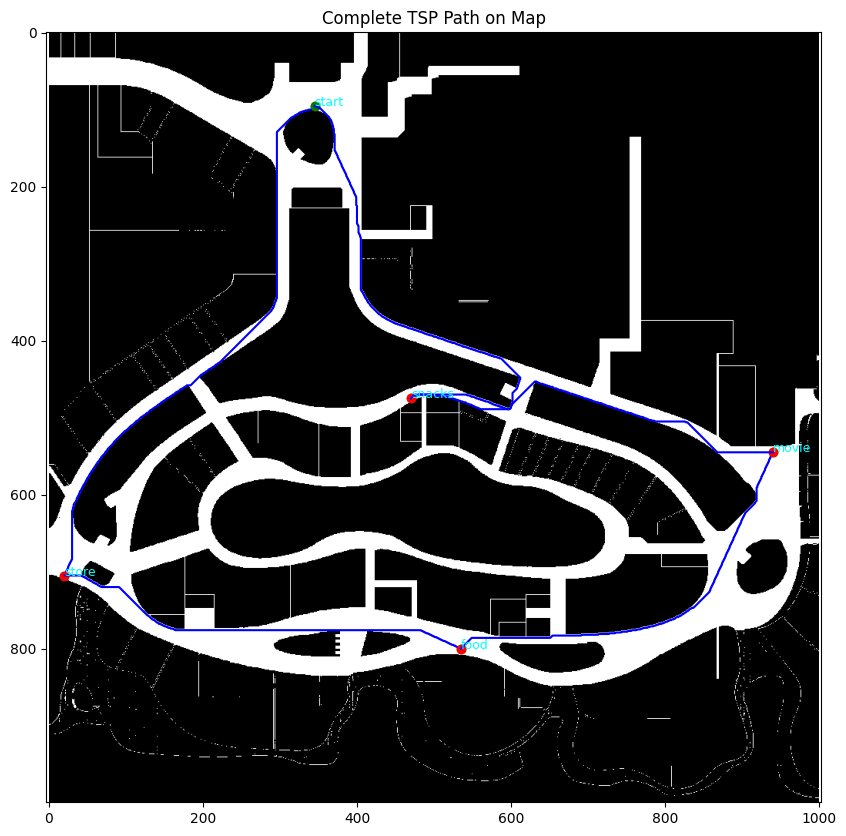

In [9]:
def brute_force_tsp(locations):
    global distances

    start_time = time.time()
    start_location_key = 'start'
    remaining_location_keys = [loc for loc in locations if loc != start_location_key]
    all_possible_paths = itertools.permutations(remaining_location_keys)

    min_path = None
    min_cost = float('inf')

    for path in all_possible_paths:
        full_path = [start_location_key] + list(path) + [start_location_key]
        cost = 0
        for i in range(len(full_path) - 1):
            # Adjusted to use precomputed distances
            pair = (full_path[i], full_path[i + 1])
            distance = distances[pair]  # Lookup the distance
            cost += distance
            print(f"Distance from {full_path[i]} to {full_path[i+1]}: {distance:.2f}")

        print(f"Total distance for this path: {cost:.2f}")
        print("-------------------------------------------------------------------------------------------------------------")
        if cost < min_cost:
            min_cost = cost
            min_path = full_path


    end_time = time.time()
    execution_time = end_time - start_time

    return min_path, min_cost, execution_time

print("Starting TSP_Brute_Force(BF)...")
path, total_distance, execution_time = brute_force_tsp(locations)
print(f"Visit order: {path}")
print(f"Total distance: {total_distance:.2f}")
print(f"Execution time: {execution_time} seconds")


plot_complete_tsp_path(path, locations)


## TSP_Dynamic_Programming(DP)

Starting TSP_Dynamic_Programming(DP)...
dp result:
Mask: 0b0 - Distances: ['inf', 'inf', 'inf', 'inf', 'inf']
Mask: 0b1 - Distances: [0, 'inf', 'inf', 'inf', 'inf']
Mask: 0b10 - Distances: ['inf', 'inf', 'inf', 'inf', 'inf']
Mask: 0b11 - Distances: ['inf', 141.96854249492426, 'inf', 'inf', 'inf']
Mask: 0b100 - Distances: ['inf', 'inf', 'inf', 'inf', 'inf']
Mask: 0b101 - Distances: ['inf', 'inf', 154.66458864299472, 'inf', 'inf']
Mask: 0b110 - Distances: ['inf', 'inf', 'inf', 'inf', 'inf']
Mask: 0b111 - Distances: ['inf', 269.2248050258503, 256.5287588777801, 'inf', 'inf']
Mask: 0b1000 - Distances: ['inf', 'inf', 'inf', 'inf', 'inf']
Mask: 0b1001 - Distances: ['inf', 'inf', 'inf', 178.65626253092572, 'inf']
Mask: 0b1010 - Distances: ['inf', 'inf', 'inf', 'inf', 'inf']
Mask: 0b1011 - Distances: ['inf', 285.59982668964443, 'inf', 248.91210665364304, 'inf']
Mask: 0b1100 - Distances: ['inf', 'inf', 'inf', 'inf', 'inf']
Mask: 0b1101 - Distances: ['inf', 'inf', 387.74196231337453, 363.7502884

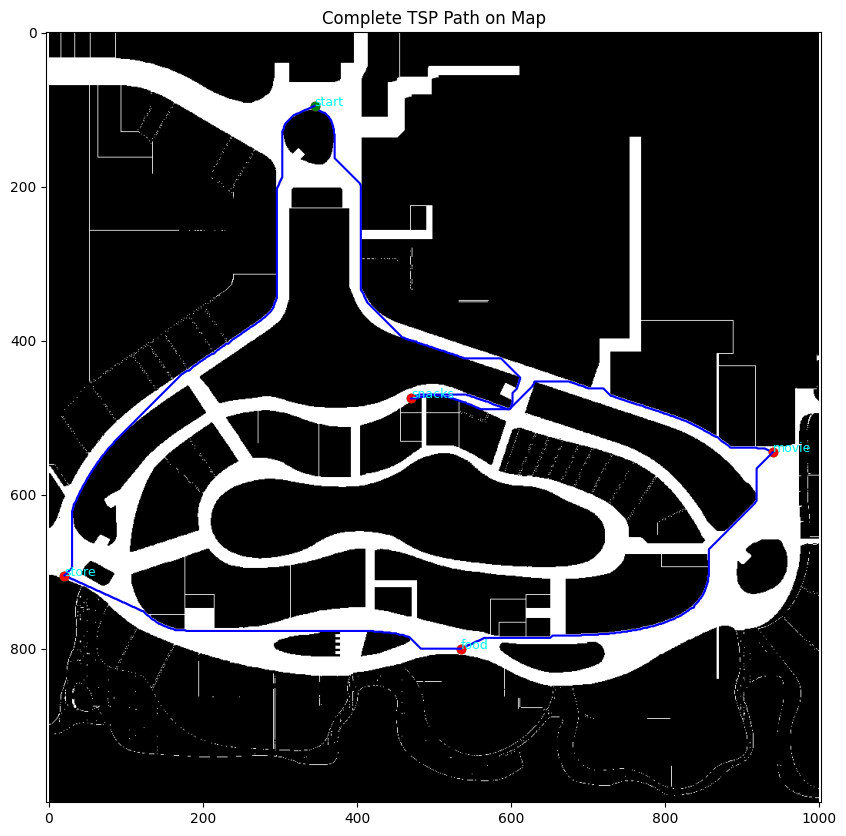

In [10]:
def dynamic_programming_tsp(locations):
    global distances
    start_time = time.time()

    n = len(locations)
    dp = [[float('inf')] * n for _ in range(1 << n)]
    parent = [[-1] * n for _ in range(1 << n)]
    dp[1][0] = 0

    location_to_index = {loc: idx for idx, loc in enumerate(locations)}
    index_to_location = {idx: loc for loc, idx in location_to_index.items()}

    for mask in range(1 << n):
        for u in range(n):
            if not mask & (1 << u):
                continue
            for v in range(n):
                if mask & (1 << v) or u == v:
                    continue
                new_mask = mask | (1 << v)
                new_cost = dp[mask][u] + distances[(index_to_location[u], index_to_location[v])]
                if new_cost < dp[new_mask][v]:
                    dp[new_mask][v] = new_cost
                    parent[new_mask][v] = u

    mask = (1 << n) - 1
    u, min_cost = min(enumerate(dp[-1]), key=lambda x: x[1])

    path = []
    while u != -1:
        path.append(index_to_location[u])
        next_u = parent[mask][u]
        mask = mask ^ (1 << u)
        u = next_u
    path.reverse()

    if path[-1] != path[0]:
        path.append(path[0])
        min_cost += distances[(path[-2], path[0])]

    end_time = time.time()
    execution_time = end_time - start_time

    print("dp result:")
    # Iterate over each subset of locations (represented as a bitmask)
    for mask in range((1 << n)):
        # Print the bitmask in binary and the corresponding distances
        print(f"Mask: {bin(mask)} - Distances: {[dp[mask][v] if dp[mask][v] != float('inf') else 'inf' for v in range(n)]}")


    return path, min_cost, execution_time

print("Starting TSP_Dynamic_Programming(DP)...")
path, total_distance, execution_time = dynamic_programming_tsp(locations)
print(f"Visit order: {path}")
print(f"Total distance: {total_distance}")
print(f"Execution time: {execution_time:.20f} seconds")

plot_complete_tsp_path(path,locations)


## TSP_Genetic Algorithm(GA)

Starting TSP_Genetic Algorithm(GA)...
Best path: ['start', 'store', 'food', 'movie', 'snacks', 'start']
Best path distance: 628.170216127768
Execution time: 0.04687571525573730469 seconds
Path from start to store: Distance = 154.66 meters
Path from store to food: Distance = 110.87 meters
Path from food to movie: Distance = 113.72 meters
Path from movie to snacks: Distance = 106.94 meters
Path from snacks to start: Distance = 141.97 meters


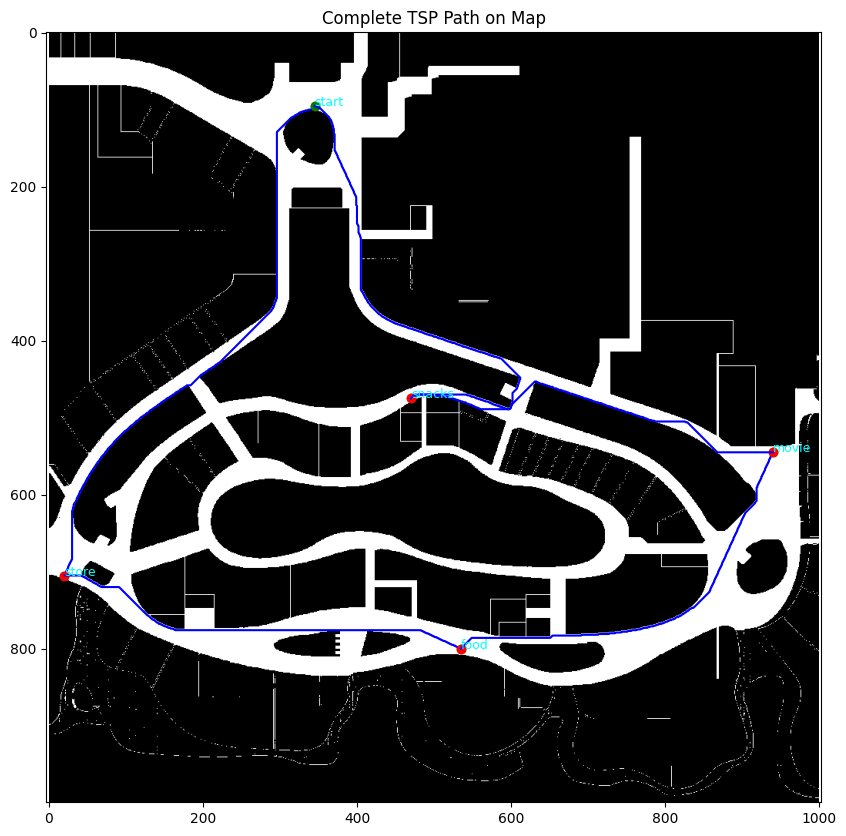

In [11]:
def genetic_algorithm_tsp(locations, distances, population_size=100, generations=100, mutation_rate=0.1, elite_size=20):
    start_time = time.time()
    location_keys = list(locations.keys())
    remaining_locations = [loc for loc in location_keys if loc != 'start']

    # Create individual
    def create_individual():
        return ['start'] + random.sample(remaining_locations, len(remaining_locations)) + ['start']

    # Fitness function
    def fitness(individual):
        path_distance = 0
        for i in range(len(individual) - 1):
            if individual[i] == individual[i + 1]:
                continue  # Skip cases where the start and end are the same
            path_distance += distances[(individual[i], individual[i + 1])]
        return 1 / path_distance

    # Crossover (ensure no city is missed or duplicated)
    def crossover(parent1, parent2):
        start, end = sorted(random.sample(range(1, len(remaining_locations)), 2))
        child_middle = parent1[start:end]
        child = ['start'] + [city for city in parent2 if city not in child_middle] + ['start']
        child[start:start] = child_middle
        return child

    # Mutation (swap two cities)
    def mutate(individual):
        if random.random() < mutation_rate:
            idx1, idx2 = random.sample(range(1, len(individual) - 1), 2)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]
        return individual

    # Selection
    def select(population, fitnesses):
        selected_indices = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)
        return [population[i] for i in selected_indices[:elite_size]] + random.choices(population, weights=fitnesses, k=population_size-elite_size)

    # Generate initial population
    population = [create_individual() for _ in range(population_size)]

    # Iteration
    for _ in range(generations):
        fitnesses = [fitness(individual) for individual in population]
        population = select(population, fitnesses)
        parents = population[:len(population) // 2]
        offspring = []
        for _ in range(len(population) // 2):
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2), crossover(parent2, parent1)
            offspring.append(mutate(child1))
            offspring.append(mutate(child2))
        population = parents + offspring

    # Select the best individual
    best_individual = max(population, key=fitness)
    best_distance = 1 / fitness(best_individual)

    end_time = time.time()
    execution_time = end_time - start_time
    return best_individual, best_distance, execution_time

print("Starting TSP_Genetic Algorithm(GA)...")
best_path, best_distance, execution_time = genetic_algorithm_tsp(locations, distances)
print("Best path:", best_path)
print("Best path distance:", best_distance)
print(f"Execution time: {execution_time:.20f} seconds")

plot_complete_tsp_path(best_path, locations)
